In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rc('figure', figsize=(10, 7))

In [2]:
tf.__version__

'1.1.0-rc2'

## Loading data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions

In [6]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = [img_size, img_size]
num_classes = 10

## Helper functions

In [7]:
# helper function to plot images
def plot_images(images, cls_true, cls_pred=None):
    img_cnt = len(images)

    # some sanity checks on inputs
    assert img_cnt == len(cls_true)
    if cls_pred is not None:
        assert img_cnt == len(cls_pred)

    # compute plot size. Do not plot more than 100 images
    plt_size = int(np.ceil(np.sqrt(img_cnt)))
    assert plt_size <= 10
    
    fig, axes = plt.subplots(plt_size, plt_size)
    
    # adjust spacing
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    empty_image = np.zeros(img_shape)

    for i, ax in enumerate(axes.flat):
        if i < img_cnt:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if cls_pred is not None:
                xlabel = 'True: {0}, Pred: {1}'.format(cls_true[i], cls_pred[i])
            else:
                xlabel = 'True: {0}'.format(cls_true[i])
        
            ax.set_xlabel(xlabel)
        else:
            ax.imshow(empty_image, cmap='binary')

        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

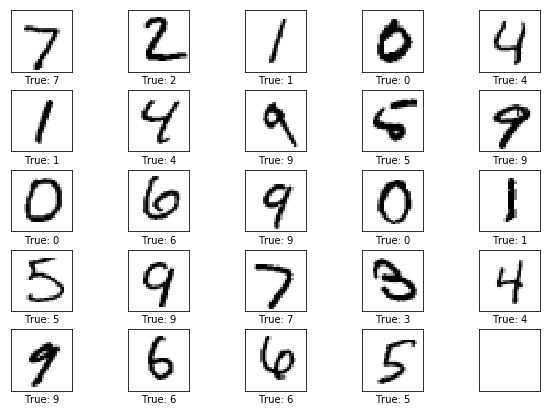

In [8]:
plot_images(data.test.images[0:24], data.test.cls[0:24])

# TensorFlow Graph

## Placeholder variables

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Weights & biases

In [10]:
weights = tf.Variable(tf.truncated_normal([img_size_flat, num_classes], mean=0.0, stddev=0.01))
biases = tf.Variable(tf.truncated_normal([num_classes], mean=0.0, stddev=0.01))

## Model

In [11]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Cost function

In [12]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Opitmization method

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
#optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance measures

In [14]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create a session

In [15]:
session = tf.Session()
session.run(tf.global_variables_initializer())

## Helper function to perform optimization iterations

In [16]:
batch_size = 128
def optimize(iterations):
    for i in range(iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict)

## Helper functions to show performance

In [17]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print('Accuracy on the test set: {0:.1%}'.format(acc))

def plot_confusion_matrix():
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)

    # plot the matrix as an image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

def plot_example_errors(num_errors=16):
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)
    
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:num_errors],
                cls_true=cls_true[0:num_errors],
                cls_pred=cls_pred[0:num_errors])

## Helper function to plot the model's weights

In [18]:
def plot_weights():
    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if i < 10:
            image = w[:, i].reshape(img_shape)
            ax.set_xlabel('Weights: {0}'.format(i))
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])

## Performance before any optimization

In [19]:
print_accuracy()

Accuracy on the test set: 14.0%


[[ 33  68  35 620   1  11  93   1 114   4]
 [  3 266   4  54  35 588   1 127  15  42]
 [ 22 323  30 226   6 120  75  25 200   5]
 [  9  71  23 550   0  68   2  11 269   7]
 [  1 550  69 210   6  63  12   6  60   5]
 [  7 240  77 133   0  73  15   1 248  98]
 [ 19 645  31 111   1  36  45   9  44  17]
 [  6 488 106  71   5  40  42 126 107  37]
 [  3 420  16 164   1  73  20   1 251  25]
 [  2 689  95  88   2  43  16   4  55  15]]


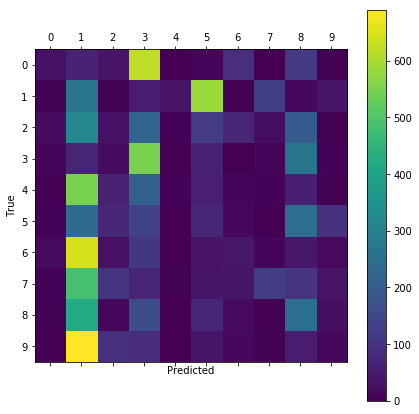

In [20]:
plot_confusion_matrix()

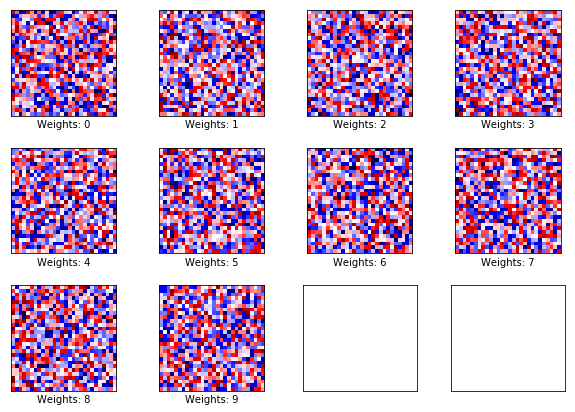

In [21]:
plot_weights()

## Performance after one iteration

In [22]:
optimize(iterations=1)

In [23]:
print_accuracy()

Accuracy on the test set: 25.6%


[[ 58   0   0  41   9   4 866   0   2   0]
 [  0   0   2   1 202 178 744   4   2   2]
 [  0   0   1  29  53   6 936   0   7   0]
 [  1   0   3 517  13  51 389   0  36   0]
 [  0   0   0   0 648  10 322   0   0   2]
 [  2   0   6  28  20 129 681   0  19   7]
 [  2   0   0   0  17   0 939   0   0   0]
 [  1   0   3   5 298  38 440 213   2  28]
 [  0   0   1  16  49  21 851   0  36   0]
 [  0   0   0   6 447  37 497   1   5  16]]


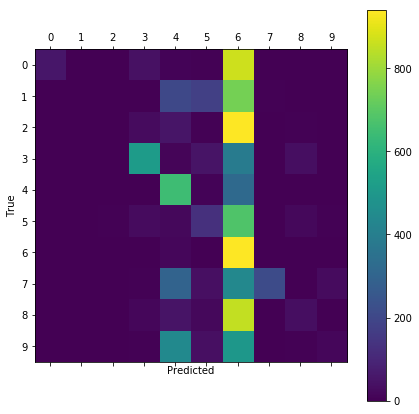

In [24]:
plot_confusion_matrix()

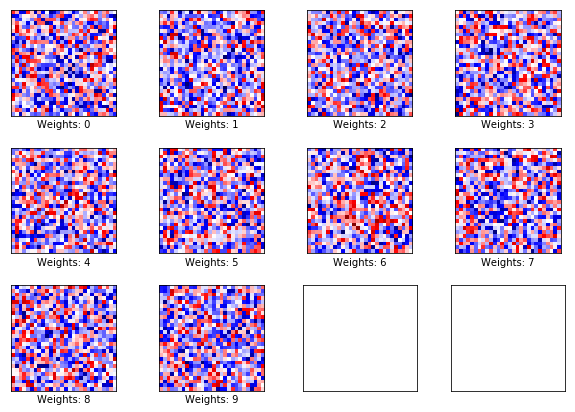

In [25]:
plot_weights()

## Performance after 10 iterations

In [26]:
optimize(iterations=9)

In [27]:
print_accuracy()

Accuracy on the test set: 73.6%


[[ 940    0    2    2    0    0   29    2    5    0]
 [   0 1069   14    8    1    4   13    1   24    1]
 [  59   65  634   46   46    0   91   43   48    0]
 [  24    8   21  851    3    2   13   44   40    4]
 [   5   10    1    0  876    1   40   10    8   31]
 [ 114   30    9  204   51  290   75   49   33   37]
 [  48    4    3    2   34    4  863    0    0    0]
 [  10   42   16    0   22    0    3  925    4    6]
 [  43   31    9   72   41    5   64   47  648   14]
 [  28   15    3   12  422    3    5  257    4  260]]


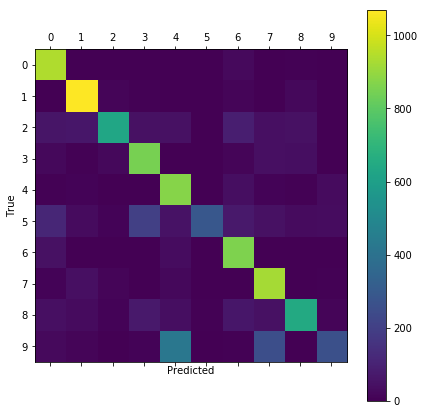

In [28]:
plot_confusion_matrix()

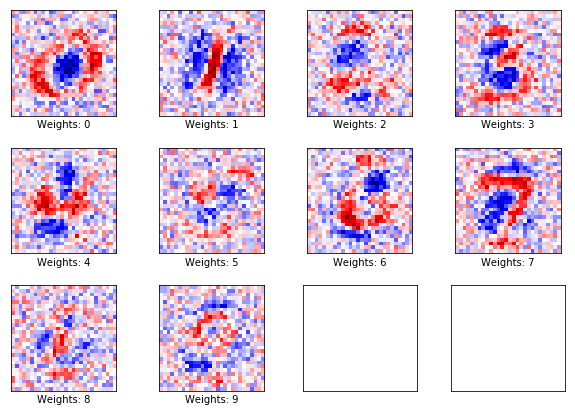

In [29]:
plot_weights()

## Performance after 1000 iterations

In [30]:
optimize(iterations=990)

In [31]:
print_accuracy()

Accuracy on the test set: 91.0%


[[ 962    0    2    2    0    3    7    1    3    0]
 [   0 1102    2    4    1    2    4    1   19    0]
 [  10    8  902   17   15    1   16   16   39    8]
 [   5    0   21  912    1   26    3    9   21   12]
 [   2    3    6    1  909    1    9    1    8   42]
 [  11    5    6   46   12  749   15   10   29    9]
 [  16    3    6    2   13   15  900    1    2    0]
 [   3   19   27    6   10    0    0  919    3   41]
 [  10    9   13   30    8   23   14   11  843   13]
 [  11    8    6   13   41   10    0   14    6  900]]


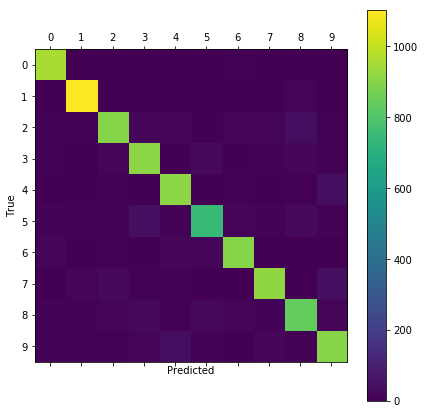

In [32]:
plot_confusion_matrix()

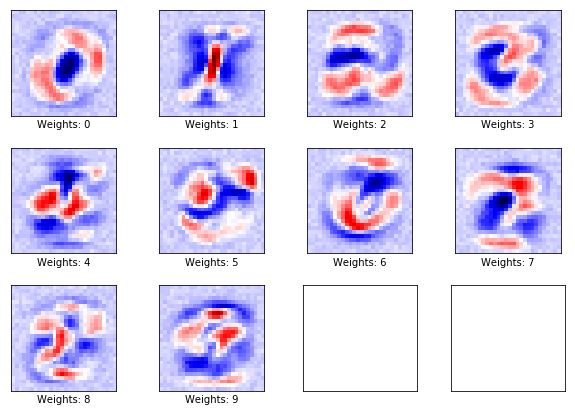

In [33]:
plot_weights()

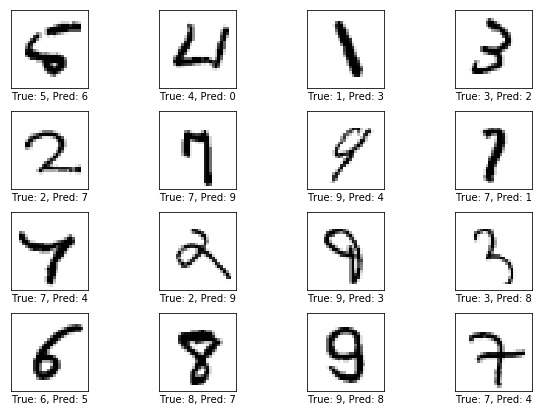

In [34]:
plot_example_errors()

## Performance after 10000 iterations

In [35]:
optimize(iterations=9000)

In [36]:
print_accuracy()

Accuracy on the test set: 92.3%


[[ 961    0    2    2    0    3    8    2    2    0]
 [   0 1110    2    2    0    1    4    2   14    0]
 [   6    9  919   16    7    4   14   11   39    7]
 [   2    0   20  923    0   23    1   13   20    8]
 [   1    2    6    1  911    0   11    3    9   38]
 [   9    3    4   36    9  766   19    6   33    7]
 [  10    3    5    2    9   13  909    3    4    0]
 [   1    6   21   10    6    1    0  949    2   32]
 [   7    6    7   23    9   22   10   10  875    5]
 [  11    7    2    8   28    7    0   29    8  909]]


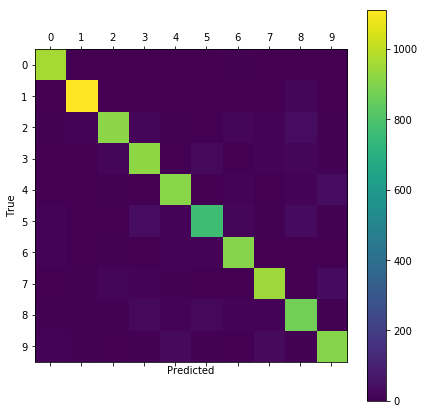

In [37]:
plot_confusion_matrix()

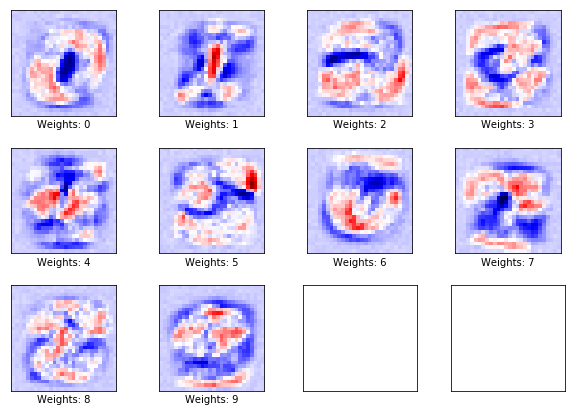

In [38]:
plot_weights()

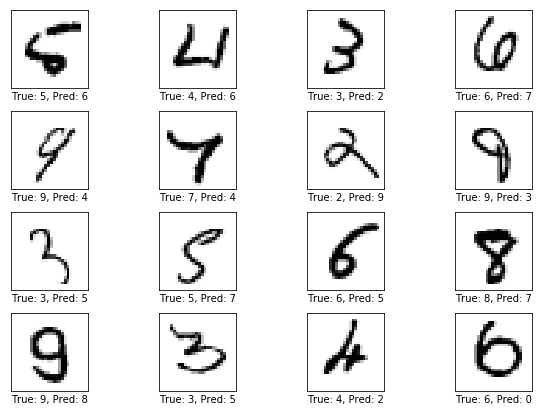

In [39]:
plot_example_errors()

In [40]:
# close TensorFlow Session
session.close()